# Machine Learning - Logistic Regression

### Introduction

In this section of the portfolio, we will go through a Machine Learning algorithm Logistic Regression to train and test the data. The data set was available from Kaggle.com's Animal Shelter Outcomes competition presented by the Austin Animal Shelter and ASPCA. 

My goal of this exercise to is create and identify a model that would accurately predict whether a sheltered animal will get adopted based on certain features. Therefore our model target in this algorithm is going to be the binary outcome of whether the animal is adopted (1) or not adopted (0). Also to note, the analysis will focus on cats only. To summarize, the data will have the following features to start off with:
- Name
- Sex
- Outcome
- Age
- Breed
- Color

### Imports

In [1]:
#Data
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

#Math
import math

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

We will first import the raw data

In [2]:
pets = pd.read_csv('/Users/data.csv')

### Data Preparation part 1

Before running any algorithms or charting, we will first prepare the data for Logistic Regression.

In [ ]:
#filter for only cats
cats = pets[pets['AnimalType']=='Cat']

#create a function for binary adopted outcome based on OutcomeType
def adoption_check(x):
    if x == 'Adoption':
        return 1 
    else:
        return 0 #Not Adopted
    
cats['Adopted'] = cats['OutcomeType'].apply(adoption_check)

#drop columns that would not add value to the model
#OutcomeSubtype contains inconsistent data and certain values are ambiguous
cats = cats.drop('OutcomeSubtype', axis=1)
#we already know this dataframe are all cats
cats = cats.drop('AnimalType', axis=1)
#OutcomeType is converted to a binary target column 'Adopted'
cats = cats.drop('OutcomeType', axis=1)
#Animal ID would not affect the outcome
cats = cats.drop('AnimalID', axis=1)
#time of which OutcomeType occurred
cats = cats.drop('DateTime', axis=1)


#convert the name column to binary values
cats['Name'].fillna(0, inplace=True)
def name_check(x):
    if x != 0:
        return 1
    else:
        return 0
    
cats['Name'] = cats['Name'].apply(name_check)

#convert null to unknown
cats['AgeuponOutcome'].fillna('Unknown', inplace=True)

#split the SexUponOutcome into 2 columns. The sex of the cat and whether they have been neutered or spayed
#then convert those into binary. The unknown columns are excluded from the final output to avoid multicollinearity
cats['SexuponOutcome'].replace(to_replace='Unknown', value='Unknown Unknown', inplace=True)

cats['Sex'] = cats.SexuponOutcome.str.split(' ').str.get(1)
cats['Neutered'] = cats.SexuponOutcome.str.split(' ').str.get(0)

cats = cats.drop('SexuponOutcome', axis=1)

def male_sex_check(x):
    if x == 'Male':
        return 1
    else:
        return 0
    
cats['Male'] = cats['Sex'].apply(male_sex_check)


def female_sex_check(x):
    if x == 'Female':
        return 1
    else:
        return 0
    
cats['Female'] = cats['Sex'].apply(female_sex_check)

def neutered_check(x):
    if x == 'Neutered' or x == 'Spayed':
        return 1
    else:
        return 0
    
cats['NeuteredSpayed'] = cats['Neutered'].apply(neutered_check)


def intact_check(x):
    if x == 'Intact':
        return 1
    else:
        return 0
    
cats['Intact'] = cats['Neutered'].apply(intact_check)

The following portion of the data preparation will attempt to categorize and simplify breed type and colors. We will also convert age into years.

In [4]:
#first create a counts bool list for color with low counts
color_count = cats['Color'].value_counts()<100
low_color_count = []
for index, elem in enumerate(color_count):
    if elem == True:
        low_color_count.append(color_count.index[index])
    else:
        pass

#map this list back to the cats table and change their values to 'unique colors'
def unique_color(color):

        if color in low_color_count:
            return 'Unique Color'
        else:
            return color
    
cats['Color'] = cats['Color'].apply(unique_color)

#consolidate other colors
torbie_tortie_calico = ('Torbie','Tortie','Calico')
tabby = ('Blue Tabby','Blue Tabby/White','Brown Tabby','Brown Tabby/White','Cream Tabby','Orange Tabby', \
         'Orange Tabby/White',)
black_white = ('White/Black','Black/White')
color_general = ('Black','Blue','Blue/White','White','Lynx Point','Seal Point','Unique Color')

def color_consolidate(colorcat):
    
    if colorcat in color_general:
        return colorcat
    else:
        pass
        
    for color in torbie_tortie_calico:
        if color in colorcat:
            return 'Torbie/Tortie/Calico'
        else: 
            pass
    for color in tabby:
        if color in colorcat:
            return 'Tabby'
        else: 
            pass
    for color in black_white:
        if color in colorcat:
            return 'Black/White'
        else: 
            pass

    
cats['Color'] = cats['Color'].apply(color_consolidate)

#now we will categorize each cats hair length by their breed type
#this was done manually by researching each breed and make a judgement call on the length of their hair
#first create a new column for their hair length
ShortHair = ('Devon Rex','Bengal','Siamese','Snowshoe','Russian Blue','Japanese Bobtail', \
    'Balinese','Bombay','Tonkinese','Sphynx','Abyssinian','Javanese','Cornish Rex', \
    'Ocicat','Havana','Burmese')
MediumHair = ('Manx','Turkish Van','Cymric','Ragdoll')
LongHair = ('Maine Coon','Himalayan','Persian','Angora','Norwegian Forest')

def asign_hair_length(hair):
    if 'Shorthair' in hair:
        return 'Shorthair'
    elif 'Medium Hair' in hair:
        return 'Medium Hair'
    elif 'Longhair' in hair:
        return 'Longhair'
    else:
        pass
    
    for breeds in ShortHair:
        if breeds in hair: 
            return 'Shorthair'
        else:
            pass
    for breeds in LongHair:
        if breeds in hair: 
            return 'Longhair'
        else:
            pass
    for breeds in MediumHair:
        if breeds in hair: 
            return 'Medium Hair'
        else:
            pass
    
cats['Hair Length'] = cats['Breed'].apply(asign_hair_length)


#dividing the breeds between domestic and exotic
#exotic meaning rarer breeds
def asign_breed_type(breeds):
    
    if 'Domestic' in breeds:
        return 'Domestic'
    else:
        return 'Exotic'
    
cats['Breed Type'] = cats['Breed'].apply(asign_breed_type)


#convert age into years
def age_in_years(age):
    if 'years' in age:
        age = int(age.replace('years',''))
    elif 'year' in age:
        age = int(age.replace('year',''))
    elif 'months' in age:
        age = int(age.replace('months','')) / 12.0
    elif 'month' in age:
        age = int(age.replace('month','')) / 12.0
    elif 'weeks' in age:
        age = int(age.replace('weeks','')) / 52.0
    elif 'week' in age:
        age = int(age.replace('week','')) / 52.0
    else:
        age = 0
    return float(age)    
    
cats['Age in Years'] = cats['AgeuponOutcome'].apply(age_in_years)

### Initial Visualizations 

Before fitting the data to the model, we'll do some initial visualizations. Based on intuition I would expect age, color/breed and whether the cat was spayed/neutered to play large roles in adoption rates. 

Below is a bar chart of color and whether they were adopted or not. As can be seen the green bars (adopted) with the least difference to the blue bars (not adopted) are the more exotic colors such as Lynx point and Seal point. 

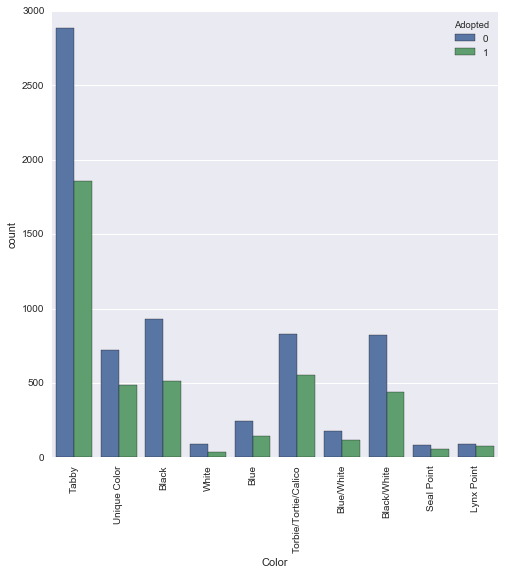

In [5]:
plot1 = sns.countplot(x='Color', hue='Adopted',data=cats)
for item in plot1.get_xticklabels():
    item.set_rotation(90)

plot1.figure.set_size_inches(8,8)

Next is a kernal density plot of the age distribution with regards to adoption. From the chart it is evident that adoption rates are densely packed between 0-1 year old, which is to be expected. Kittens and young cats are expected to have an easier time with getting adopted. 

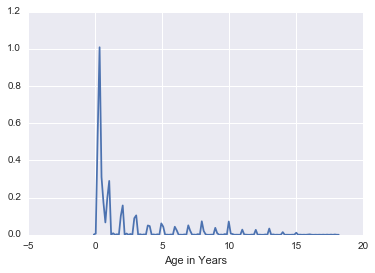

In [11]:
age_plot = cats[cats['Adopted']==1]
age_plot = age_plot['Age in Years']
sns.distplot(age_plot,hist=False)

### Data Preparation part 2 - Dummy variables 

We'll now continue to finalize our data preparation by creating dummy variables for breed, color and hair length. Also note that a column from each set of category was dropped to help mitigate multicollinearity in our model. 

In [7]:
#create dummies for Hair Length, Breed Type and Color
hair_dummies = pd.get_dummies(cats['Hair Length'])
breed_dummies = pd.get_dummies(cats['Breed Type'])
color_dummies = pd.get_dummies(cats['Color'])

#create a new dataframe X to run our model
X = cats.drop(['AgeuponOutcome','Breed','Color','Sex','Neutered','Hair Length','Breed Type'], axis=1)

#concatenate the dummies
dummies = pd.concat([hair_dummies,breed_dummies,color_dummies],axis=1)

#concatenate to the base dataframe X 
X = pd.concat([X,dummies],axis=1)

#prepare for target Y
Y = X.Adopted

#drop Adopted from X
X = X.drop('Adopted',axis=1)

#drop a column from each set of dummy to avoid multicollinearity
X = X.drop(['Shorthair','Domestic','Blue/White','Seal Point'],axis=1)
#drop all unknown related categories as it may distort the model
X = X.drop(['Male','Female','NeuteredSpayed','Intact'],axis=1)

#flatten Y array in order to use scikit learn
Y = np.ravel(Y)

### Logistic Regression

With the dataframe X setup complete, we can now use Scikit Learn to run our Logistic Regression. 

In [8]:
model = LogisticRegression()
model.fit(X,Y)
model.score(X,Y)

0.73019579665888268

In [9]:
#null error rate
1 - Y.mean()

0.6163104005748159

From our model we obtained a 73% accuracy score for out Logistic Regression model. Next step is to check to see how much better or worse our model is compared to the null error rate. The null error rate was 62% which meant that the model was 11% than if we had guessed every outcome was null. 

Now lets take a look at the coefficients and Odds ratio to see which of the features played a larger role in determining the adoption outcome.

In [13]:
#create a coefficient dataframe
coef = DataFrame(zip(X.columns,np.transpose(model.coef_)))
coef.columns = ['Features','Coefficient']

#odds ratio
def odds_ratio(value):

    for col in value:
        return np.exp(value)
    else:
        pass

coef['Odds Ratio'] = coef['Coefficient'].apply(odds_ratio)
coef

,Features,Coefficient,Odds Ratio
0,Name,[2.42217842407],[11.2703842687]
1,Age in Years,[-0.144884403409],[0.865122292518]
2,Longhair,[0.18547061325],[1.20378482393]
3,Medium Hair,[0.180291673276],[1.19756661036]
4,Exotic,[0.234896003403],[1.26477722937]
5,Black,[-0.187432164539],[0.82908535766]
6,Black/White,[-0.192612473282],[0.82480154485]
7,Blue,[0.0281816607871],[1.02858252056]
8,Lynx Point,[0.232282237563],[1.26147571442]
9,Tabby,[0.0579912767139],[1.05970575155]


With the Odds Ratio computed we can do a deeper dive into analyzing which features played a larger role in determining whether a cat will get adopted or not. 

Let's point to some of the more obvious results first. Age in Years had a 0.87 ratio and as you would expect as a cats age increase, the odds of it being adopted will be lower. Cats with medium/long hair would have a higher ratio than if they were short. This is inline with the high odds ratio of exotic breeds and lynx point, which points to the fact that rarer/exotic cats have a increased likelihood of adoption. Long/medium hair cats are generally associated with rarer breeds. 

The most interesting and surprising insight coming out of this model was the extremely high odds ration of the Name feature. What this means is cats that have a name are much more likely to get adopted than cats that have no name. This will be an interesting study going forward to see whether giving the adoption animal a name will increase their chance of adoption. 

### Train and Test the data

Now that we've evaluated the model, it is time to split the data to train and test the model. 

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
model_2 = LogisticRegression()
model_2.fit(X_train,Y_train)

prediction = model_2.predict(X_test)

print metrics.accuracy_score(Y_test,prediction)

0.744971264368


With the data split into testing and training, we were able to obtain a 74% accuracy score, which was similar to our original score.



I hope this analysis of sheltered animals provided some interesting insights and ideas. Thank you very much for reading through this analysis and hope you've enjoyed it as much as I did.

Mitsuaki Takeo